In [1]:
from graphviz import Digraph, Graph
from antlr4 import *
from trustmessages import *

In [2]:
class GraphVisitorFull(ParseTreeVisitor):

    def __init__(self):
        super(GraphVisitorFull, self).__init__()
        self.g = Graph(graph_attr={"rankdir": "BT"}, node_attr={"shape": "plaintext"})

    def find_parent(self, ctx):
        parent = ctx.parentCtx
        while isinstance(parent, QueryParser.ParenthesisContext):
            parent = parent.parentCtx
        return parent

    def visitConstraint(self, ctx):
        self.g.node(str(ctx) + str(ctx.FIELD()), str(ctx.FIELD()))
        self.g.edge(str(ctx) + str(ctx.FIELD()), str(ctx))
        self.g.node(str(ctx) + str(ctx.OP()), str(ctx.OP()))
        self.g.edge(str(ctx) + str(ctx.OP()), str(ctx))
        self.g.node(str(ctx) + str(ctx.VALUE()), str(ctx.VALUE()))
        self.g.edge(str(ctx) + str(ctx.VALUE()), str(ctx))
        self.g.node(str(ctx), "expr")  
        self.g.edge(str(ctx), str(ctx.parentCtx))
              
    def visitOr(self, ctx):
        self.g.node(str(ctx), "expr")
        self.g.edge(str(ctx), str(ctx.parentCtx))
        self.visit(ctx.expr(0))
        self.g.node(str(ctx) + "OR", "OR")
        self.g.edge(str(ctx) + "OR", str(ctx))
        self.visit(ctx.expr(1))
        
    def visitAnd(self, ctx):
        self.g.node(str(ctx), "expr")
        self.g.edge(str(ctx), str(ctx.parentCtx))
        self.visit(ctx.expr(0))
        self.g.node(str(ctx) + "AND", "AND")
        self.g.edge(str(ctx) + "AND", str(ctx))
        self.visit(ctx.expr(1))

    def visitParenthesis(self, ctx):
        self.g.node(str(ctx), "expr")
        self.g.edge(str(ctx), str(ctx.parentCtx))
        self.g.node(str(ctx) + "(", "(")
        self.g.edge(str(ctx) + "(", str(ctx))
        self.visit(ctx.expr())
        self.g.node(str(ctx) + ")", ")")
        self.g.edge(str(ctx) + ")", str(ctx))

In [3]:
examples = [
    "target = bob AND (service = seller OR service = buyer) AND date > 1499356643",
    "service = renter",
    "((service = renter))",
    "service = renter AND target = alice",
    "service = renter AND (target = alice OR target = bob)",
    "service = renter AND target = alice OR target = bob",
    "date = 6 OR date = 7 AND target = alice OR date = 8",
    "(date = 6 OR date = 7) AND (target = alice OR date = 8)"
]

def draw_graph(input_, visitor):
    lexer = QueryLexer.QueryLexer(InputStream(input_))
    stream = CommonTokenStream(lexer)
    parser = QueryParser.QueryParser(stream)
    tree = parser.expr()
    visitor.visit(tree)
    return visitor.g

target = bob AND (service = seller OR service = buyer) AND date > 1499356643


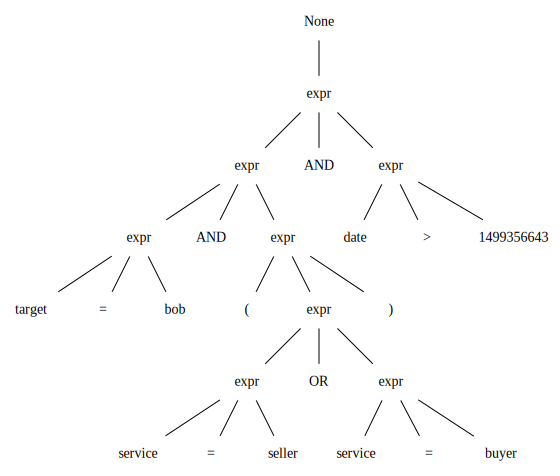

In [4]:
example = examples[0]
print(example)
draw_graph(example, GraphVisitorFull())

In [5]:
class GraphVisitorCompact(ParseTreeVisitor):

    def __init__(self):
        super(GraphVisitorCompact, self).__init__()
        self.g = Graph(graph_attr={"rankdir": "BT"}, node_attr={"shape": "ellipse"})

    def find_parent(self, ctx):
        parent = ctx.parentCtx
        while isinstance(parent, QueryParser.QueryParser.ParenthesisContext):
            parent = parent.parentCtx
        return parent

    def visitConstraint(self, ctx):
        label = "%s %s %s" % (ctx.FIELD(), ctx.OP(), ctx.VALUE())
        self.g.node(str(ctx), label)        
        # self.g.edge(str(ctx), str(self.find_parent(ctx)), label="Comparison")
        self.g.edge(str(ctx), str(self.find_parent(ctx)))
              
    def visitOr(self, ctx):
        self.visit(ctx.expr(0))
        self.visit(ctx.expr(1))
        self.g.node(str(ctx), "OR")
        self.g.edge(str(ctx), str(self.find_parent(ctx)))
        # self.g.edge(str(ctx), str(self.find_parent(ctx)), label="Logical")

    def visitAnd(self, ctx):
        self.visit(ctx.expr(0))
        self.visit(ctx.expr(1))
        self.g.node(str(ctx), "AND")
        self.g.edge(str(ctx), str(self.find_parent(ctx)))
        # self.g.edge(str(ctx), str(self.find_parent(ctx)), label="Logical")

    def visitParenthesis(self, ctx):
        self.visit(ctx.expr())

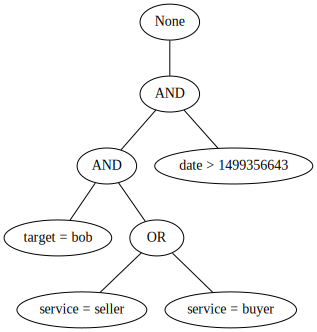

In [6]:
draw_graph(example, GraphVisitorCompact())